In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchsummary import summary

from matplotlib import pyplot as plt

import modules
from utils import dataset
from modules import encoder_ALL, generator_ALL, discriminator_ALL

import time
import numpy as np
from imp import reload
import seaborn as sns
from sklearn import metrics
from scipy import stats

/home/laya/anaconda3/envs/t13/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
normalize = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.RandomVerticalFlip(),
                                torchvision.transforms.RandomCrop(220),
                                torchvision.transforms.ToTensor(),
                                normalize])
norm_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])
test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                torchvision.transforms.FiveCrop(220),
                                torchvision.transforms.Lambda(lambda crops: torch.stack([norm_transform(crop)
                                for crop in crops]))
                                ])

In [4]:
reload(dataset)
training_data = dataset.ImageFolderPaths('./data/Leukemia/train', transform = transform)
test_data = dataset.ImageFolderPaths('./data/Leukemia/test/', transform = test_transform)

In [4]:
data_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size= 16,
                                          shuffle=True,
                                          num_workers= 0)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size= 1,
                                          shuffle=True,
                                          num_workers= 1)

In [5]:
learning_rate = 1e-4
beta1 = 0.5
beta2 = 0.999
num_epochs = 1000
latent_size = 200

In [6]:
dis_criterion = nn.CrossEntropyLoss()
aen_criterion = nn.MSELoss()

In [7]:
device = torch.device('cuda')

In [8]:
reload(encoder_new)
reload(generator_new)
reload(discriminator_new)
enc = encoder_new.Encoder(latent_size)
gen = generator_new.Generator(latent_size)
dis = discriminator_new.Discriminator(latent_size)

In [9]:
# summary(enc, (3, 220, 220))

In [10]:
# summary(gen, (200, 1, 1))

In [11]:
# summary(dis, (3, 220, 220))

mean negative: 0.2459, std negative: 0.0177
mean positive: 0.4152, std positive: 0.0636
4
1
tp: 129, fp: 4, fn: 1, tn: 26
precision: 0.96992, recall: 0.99231, specificity: 0.86667, f1: 0.98099, fp_rate: 0.13333, accuracy: 0.96875
auc 0.9984615384615385

mean negative: 0.2305, std negative: 0.0343
mean positive: 0.5170, std positive: 0.1220
2
4
tp: 126, fp: 2, fn: 4, tn: 28
precision: 0.98438, recall: 0.96923, specificity: 0.93333, f1: 0.97674, fp_rate: 0.06667, accuracy: 0.96250
auc 0.9935897435897436

mean negative: 0.1666, std negative: 0.0343
mean positive: 0.5913, std positive: 0.2080
1
10
tp: 120, fp: 1, fn: 10, tn: 29
precision: 0.99174, recall: 0.92308, specificity: 0.96667, f1: 0.95618, fp_rate: 0.03333, accuracy: 0.93125
auc 0.9758974358974359


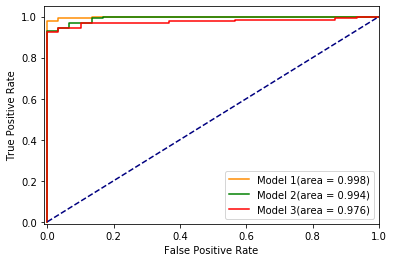

In [20]:
## model 1 (random seed 10)
gen.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/10/G.pt'))
enc.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/10/E.pt'))
dis.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/10/D.pt'))

dis.to(device)
enc.to(device)
gen.to(device);

dis.eval()
gen.eval()
enc.eval()

lam = 0.8
betha = 0.01
loss_neg = torch.zeros((30,1)).cuda()
loss_pos = torch.zeros((130,1)).cuda()
c_neg = c_pos = 0
for step, (images, labels, path) in enumerate(test_loader, 0):
    images = images.view(-1, 3, 220, 220)
    x_real_test = images.cuda()
    E_x = enc(x_real_test)
    G_z = gen(E_x)
    
    E_G_z = enc(G_z)
    
    real, internal_real = dis(x_real_test)
    fake, internal_fake = dis(G_z)
    
    latentloss = torch.mean(torch.abs(E_x - E_G_z))
    resloss = torch.mean(torch.abs(x_real_test - G_z))
    discloss = torch.mean(torch.abs(internal_real - internal_fake))
    loss_test = ((1 - lam) * resloss + lam * discloss) + betha * latentloss
    
    if '0.tif' in str(path):
        loss_neg[c_neg] = loss_test.detach()
        c_neg += 1
    else:
        loss_pos[c_pos] = loss_test.detach()
        c_pos += 1

print ('mean negative: %0.4f, std negative: %0.4f' %(torch.mean(loss_neg), torch.std(loss_neg)))
print ('mean positive: %0.4f, std positive: %0.4f' %(torch.mean(loss_pos), torch.std(loss_pos)))

x1 = loss_neg.cpu().numpy()
x2 = loss_pos.cpu().numpy()

FP = TP = []
neg_pre_wrong = 0
for i in range(len(loss_neg)):
    if loss_neg[i] > 0.28:
        neg_pre_wrong += 1
        
print (neg_pre_wrong)
pos_pre_wrong = 0
for i in range(len(loss_pos)):
    if loss_pos[i] <= 0.28:
        pos_pre_wrong += 1
print (pos_pre_wrong)

tp = (len(loss_pos) - pos_pre_wrong)
fn = pos_pre_wrong
fp = neg_pre_wrong
tn = len(loss_neg) - neg_pre_wrong
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fp_rate = fp / (fp + tn)
specificity = tn / (tn + fp)
f1 = 2 * ((precision * recall)/(precision + recall))
accuracy = (tp + tn) / (tp + tn + fp + fn)
print ("tp: %d, fp: %d, fn: %d, tn: %d" %(tp, fp, fn, tn))
print ("precision: %.5f, recall: %.5f, specificity: %.5f, f1: %.5f, fp_rate: %.5f, accuracy: %.5f" 
       %(precision, recall, specificity, f1, fp_rate, accuracy))

anomalous = torch.ones((len(loss_pos), 1))
normal = torch.zeros((len(loss_neg), 1))
y = torch.cat((anomalous, normal), 0)
scores = torch.cat((loss_pos, loss_neg), 0)
fpr_model1, tpr_model1, thresholds = metrics.roc_curve(y.cpu(), scores.cpu())
auc_model1 = metrics.auc(fpr_model1, tpr_model1)
print ('auc', auc_model1)
print ()


### model 2 (random seed 100)

gen.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/100/G.pt'))
enc.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/100/E.pt'))
dis.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/100/D.pt'))

dis.to(device)
enc.to(device)
gen.to(device);

dis.eval()
gen.eval()
enc.eval()

lam = 0.8
loss_neg = torch.zeros((30,1)).cuda()
loss_pos = torch.zeros((130,1)).cuda()
c_neg = c_pos = 0
for step, (images, labels, path) in enumerate(test_loader, 0):
    images = images.view(-1, 3, 220, 220)
    x_real_test = images.cuda()
    E_x = enc(x_real_test)
    G_z = gen(E_x)
    
    E_G_z = enc(G_z)
    
    real, internal_real = dis(x_real_test)
    fake, internal_fake = dis(G_z)
    
    latentloss = torch.mean(torch.abs(E_x - E_G_z))
    resloss = torch.mean(torch.abs(x_real_test - G_z))
    discloss = torch.mean(torch.abs(internal_real - internal_fake))
    loss_test = ((1 - lam) * resloss + lam * discloss) + betha * latentloss
    
    if '0.tif' in str(path):
        loss_neg[c_neg] = loss_test.detach()
        c_neg += 1
    else:
        loss_pos[c_pos] = loss_test.detach()
        c_pos += 1

print ('mean negative: %0.4f, std negative: %0.4f' %(torch.mean(loss_neg), torch.std(loss_neg)))
print ('mean positive: %0.4f, std positive: %0.4f' %(torch.mean(loss_pos), torch.std(loss_pos)))

x1 = loss_neg.cpu().numpy()
x2 = loss_pos.cpu().numpy()

FP = TP = []
neg_pre_wrong = 0
for i in range(len(loss_neg)):
    if loss_neg[i] > 0.29:
        neg_pre_wrong += 1
        
print (neg_pre_wrong)
pos_pre_wrong = 0
for i in range(len(loss_pos)):
    if loss_pos[i] <= 0.29:
        pos_pre_wrong += 1
print (pos_pre_wrong)

tp = (len(loss_pos) - pos_pre_wrong)
fn = pos_pre_wrong
fp = neg_pre_wrong
tn = len(loss_neg) - neg_pre_wrong
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fp_rate = fp / (fp + tn)
specificity = tn / (tn + fp)
f1 = 2 * ((precision * recall)/(precision + recall))
accuracy = (tp + tn) / (tp + tn + fp + fn)
print ("tp: %d, fp: %d, fn: %d, tn: %d" %(tp, fp, fn, tn))
print ("precision: %.5f, recall: %.5f, specificity: %.5f, f1: %.5f, fp_rate: %.5f, accuracy: %.5f" 
       %(precision, recall, specificity, f1, fp_rate, accuracy))

anomalous = torch.ones((len(loss_pos), 1))
normal = torch.zeros((len(loss_neg), 1))
y = torch.cat((anomalous, normal), 0)
scores = torch.cat((loss_pos, loss_neg), 0)
fpr_model2, tpr_model2, thresholds = metrics.roc_curve(y.cpu(), scores.cpu())
auc_model2 = metrics.auc(fpr_model2, tpr_model2)
print ('auc', auc_model2)
print ()

### model 3 (random seed 0)

gen.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/withRandomCrop_99%/G.pt'))
enc.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/withRandomCrop_99%/E.pt'))
dis.load_state_dict(torch.load('./models/Leukemia/RandomSeedTest/withRandomCrop_99%/D.pt'))

dis.to(device)
enc.to(device)
gen.to(device);

dis.eval()
gen.eval()
enc.eval()

lam = 0.8
loss_neg = torch.zeros((30,1)).cuda()
loss_pos = torch.zeros((130,1)).cuda()
c_neg = c_pos = 0
for step, (images, labels, path) in enumerate(test_loader, 0):
    images = images.view(-1, 3, 220, 220)
    x_real_test = images.cuda()
    E_x = enc(x_real_test)
    G_z = gen(E_x)
    
    E_G_z = enc(G_z)
    
    real, internal_real = dis(x_real_test)
    fake, internal_fake = dis(G_z)
    
    latentloss = torch.mean(torch.abs(E_x - E_G_z))
    resloss = torch.mean(torch.abs(x_real_test - G_z))
    discloss = torch.mean(torch.abs(internal_real - internal_fake))
    loss_test = ((1 - lam) * resloss + lam * discloss) + betha * latentloss
    
    if '0.tif' in str(path):
        loss_neg[c_neg] = loss_test.detach()
        c_neg += 1
    else:
        loss_pos[c_pos] = loss_test.detach()
        c_pos += 1

print ('mean negative: %0.4f, std negative: %0.4f' %(torch.mean(loss_neg), torch.std(loss_neg)))
print ('mean positive: %0.4f, std positive: %0.4f' %(torch.mean(loss_pos), torch.std(loss_pos)))

x1 = loss_neg.cpu().numpy()
x2 = loss_pos.cpu().numpy()

FP = TP = []
neg_pre_wrong = 0
for i in range(len(loss_neg)):
    if loss_neg[i] > 0.27:
        neg_pre_wrong += 1
        
print (neg_pre_wrong)
pos_pre_wrong = 0
for i in range(len(loss_pos)):
    if loss_pos[i] <= 0.27:
        pos_pre_wrong += 1
print (pos_pre_wrong)

tp = (len(loss_pos) - pos_pre_wrong)
fn = pos_pre_wrong
fp = neg_pre_wrong
tn = len(loss_neg) - neg_pre_wrong
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fp_rate = fp / (fp + tn)
specificity = tn / (tn + fp)
f1 = 2 * ((precision * recall)/(precision + recall))
accuracy = (tp + tn) / (tp + tn + fp + fn)
print ("tp: %d, fp: %d, fn: %d, tn: %d" %(tp, fp, fn, tn))
print ("precision: %.5f, recall: %.5f, specificity: %.5f, f1: %.5f, fp_rate: %.5f, accuracy: %.5f" 
       %(precision, recall, specificity, f1, fp_rate, accuracy))

anomalous = torch.ones((len(loss_pos), 1))
normal = torch.zeros((len(loss_neg), 1))
y = torch.cat((anomalous, normal), 0)
scores = torch.cat((loss_pos, loss_neg), 0)
fpr_model3, tpr_model3, thresholds = metrics.roc_curve(y.cpu(), scores.cpu())
auc_model3 = metrics.auc(fpr_model3, tpr_model3)
print ('auc', auc_model3)


plt.figure()
plt.plot(fpr_model1, tpr_model1, color='darkorange', label='Model 1(area = %0.3f)' % auc_model1)
plt.plot(fpr_model2, tpr_model2, color='green', label='Model 2(area = %0.3f)' % auc_model2)
plt.plot(fpr_model3, tpr_model3, color='red', label='Model 3(area = %0.3f)' % auc_model3)
plt.plot([0.0, 1.0], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show();

In [21]:
# with new loos and betha = 0.01
sen = [0.9923, 0.9692, 0.9231]
spe = [0.8667, 0.9333, 0.9667]
f1 = [0.9810, 0.9767, 0.9562]
acc = [0.9688, 0.9625, 0.9313]
auc = [0.9985, 0.9936, 0.9759]

sen_mean = np.mean(sen)
sen_std = np.std(sen)

spe_mean = np.mean(spe)
spe_std = np.std(spe)

f1_mean = np.mean(f1)
f1_std = np.std(f1)

acc_mean = np.mean(acc)
acc_std = np.std(acc)

auc_mean = np.mean(auc)
auc_std = np.std(auc)


print (sen_mean, sen_std)
print (spe_mean, spe_std)
print (f1_mean, f1_std)
print (acc_mean, acc_std)
print (auc_mean, auc_std)

0.9615333333333332 0.02876622247629246
0.9222333333333333 0.0415680432811339
0.9712999999999999 0.010820659252867456
0.9542 0.0163957311517358
0.9893333333333333 0.009707156581043154
